# Extra lab 1 - Basics of Autograd in Python

In this extra laboratory, we will learn a few concepts about autograd in PyTorch and how to build modules with a custom backward pass.

## Building a computational graph and obtaining derivatives

A computational graph in PT is automatically constructed by just applying some operations on one or more PT tensors.

Let us reproduce the example from prof. Manzoni's lecture:

![](img/compgraph.png)

Input (leaf) tensors are indicated in yellow circles, gray circles indicate intermediate tensors, blue circles output tensors, operations are shown in black squares.

### Gradient flow for $y_1$

Suppose we wish to calculate $\frac{\partial y_1}{\partial x_1}$. Thanks to the chain rule and the linearity of the derivative operator, we can decompose it in the following way: $\frac{\partial y_1}{\partial b}\frac{\partial b}{\partial x_1} + \frac{\partial y_1}{\partial a}\frac{\partial a}{\partial x_1}$.

Now, $\frac{\partial y_1}{\partial b}=\frac{\partial a+b}{\partial b}=1$. The same with $\frac{\partial y_1}{\partial a}$.

On the other hand, $\frac{\partial b}{\partial x_1} = \frac{\partial \cos(x_1)}{\partial x_1} = -\sin(x_1)$, and $\frac{\partial a}{\partial x_1} = \frac{\partial x_1 x_2}{\partial x_1} = x_2$.

We hence have all we need to calculate the gradient, we just need to assign a given value to $x_1, x_2$, say, $3$ and $2$.

Now, backpropagation:

$\frac{\partial y_1}{\partial a}=\frac{\partial y_1}{\partial b}=1$

$\frac{\partial b}{\partial x_1}\frac{\partial y_1}{\partial b}=-\sin(x_1)\cdot 1= -0.14 $

$\frac{\partial a}{\partial x_1}\frac{\partial y_1}{\partial a}=x_2\cdot 1= 2$

$\frac{\partial y_1}{\partial b}\frac{\partial b}{\partial x_1} + \frac{\partial y_1}{\partial a}\frac{\partial a}{\partial x_1} = 2-0.14 = 1.86$ 

Similarly, for $x_2$,

$\frac{\partial y_1}{\partial a}=\frac{\partial y_1}{\partial b}=1$

$\frac{\partial b}{\partial x_2}\frac{\partial y_1}{\partial b}=0 \cdot 1= 0 $

$\frac{\partial a}{\partial x_2}\frac{\partial y_1}{\partial a}=3 \cdot 1= 3$

$\frac{\partial y_1}{\partial b}\frac{\partial b}{\partial x_2} + \frac{\partial y_1}{\partial a}\frac{\partial a}{\partial x_2} = 3$ 

In [ ]:
import torch
from matplotlib import pyplot as plt

We construct the tensor by specifying `requires_grad=True` in the constructor. If we don't do it, the gradient information won't be retained for the specific leaf tensor.

In [20]:
x_1 = torch.tensor([3.0], requires_grad=True)
x_2 = torch.tensor([2.0], requires_grad=True)
print(x_1)
print(x_2)

tensor([3.], requires_grad=True)
tensor([2.], requires_grad=True)


By obtaining and printing `a`, we can see that the tensor has a specific gradient function attached.

In [64]:
x_1.grad = None
a = x_1 * x_2
print(a)

tensor([6.], grad_fn=<MulBackward0>)


In [65]:
b = x_1.cos()
y_1 = a + b
print(y_1)

tensor([5.0100], grad_fn=<AddBackward0>)


In [23]:
d = x_1.log()
e = x_2 ** 3
g = d + e
y_2 = g - x_2
print(y_2)

tensor([7.0986], grad_fn=<SubBackward0>)


In [24]:
f = torch.stack((y_1, y_2))
print(f)

tensor([[5.0100],
        [7.0986]], grad_fn=<StackBackward>)


We ask Python to calculate the gradient with the `backward` method.

Note: `backward()` may be called only on singleton tensors!

In [25]:
f.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

We then call `backward()` on the two scalars composing it. We also call `retain_graph=True` on the first try since each time a vanilla `backward()` is called, PT deletes the underlying computational graph for efficiency reasons.

In [26]:
f[0].backward() # equivalent to y_1.backward()

Let us analyze the gradients:

In [27]:
e.grad

<ipython-input-27-d5fb09b6846b>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  e.grad


Indeed, the grad is stored (again, for efficiency reasons) only on the leaf tensors. You may use [hooks](https://www.youtube.com/watch?v=syLFCVYua6Q) to retain also intermediate grads.

In [28]:
print(x_1.grad, "\n")
print(x_2.grad)

tensor([1.8589]) 

tensor([3.])


Let's do it the quick way:

In [29]:
ff = torch.stack([
    x_1 * x_2 + x_1.cos(),
    x_1.log() + x_2 ** 3 - x_2
])
ff[0].backward(retain_graph=True)
ff[1].backward()
print(ff)
print(x_1.grad, "\n")
print(x_2.grad)

tensor([[5.0100],
        [7.0986]], grad_fn=<StackBackward>)
tensor([4.0511]) 

tensor([17.])


**Q**: what did we do here?

Answer: we called `.backward()` twice (the first time retaining the graph, which would otherwise be deleted by PT upon the first `backward` call). The gradients have then been accumulated.

Note that PT by itself cannot compute Jacobians directly: they have to be created by calling `backward` on each of the scalar composing the output of the function and the gradients on the leaves stored somewhere else (this is one of the downsides of backprop of which Manzoni was talking before).

I.e., if we have $f:\mathbb{R}^d\rightarrow\mathbb{R}$, we can obtain the gradients of $\mathbf{x}\in\mathbb{R}^d$ in one-shot by calling `.backward()` on $f(\mathbf{x})$. But, if $f:\mathbb{R}^d\rightarrow\mathbb{R}^p$, we have to compute separately $\partial{f_j}/\partial{\mathbf{x}}$ each time by executing a backward pass on $f_j(\mathbf{x})$, storing the gradient somewhere else (e.g., in a matrix $J\in\mathbb{R}^{p\times d}$) and clearing the gradient (so it doesn't get accumulated).

The problem of **gradient accumulation** can be seen also in this other example. If we execute this cell multiple times, we'll see that the gradients start growing

In [69]:
ff = torch.stack([
    x_1 * x_2 + x_1.cos(),
    x_1.log() + x_2 ** 3 - x_2
])
ff[1].backward()
print(ff)
print(x_1.grad, "\n")
print(x_2.grad)

tensor([[5.0100],
        [7.0986]], grad_fn=<StackBackward>)
tensor([0.6667]) 

tensor([22.])


**Q**: why does it keep on growing?

Answer: because each time we're accumulating the current gradient to the previous grad stored in x_1 and x_2.

The gradient must be cleared by setting it to `None`. This is actually what `model.zero_grad()` and `optimizer.zero_grad()` do in our model training routines.

Try executing this cell below multiple times: you'll see the gradient doesn't change:

In [75]:
x_1.grad = None
x_2.grad = None
ff = torch.stack([
    x_1 * x_2 + x_1.cos(),
    x_1.log() + x_2 ** 3 - x_2
])
ff[1].backward()
print(ff)
print(x_1.grad, "\n")
print(x_2.grad)

tensor([[5.0100],
        [7.0986]], grad_fn=<StackBackward>)
tensor([0.3333]) 

tensor([11.])


## Building a custom non-parametric module

Basically, we want to create a module which is not controlled by any parameter, be it trainable or non-trainable.

As an example, we might have the Leaky ReLU, an activation function which can be used in place of the more-known ReLU.

$\text{Leaky_ReLU} = \max\{0.01\cdot x, x\}$

![](https://i1.wp.com/clay-atlas.com/wp-content/uploads/2019/10/image-37.png?resize=640%2C480&ssl=1)

We could do it with the basic PyTorch Tensor methods, like we did at the end of Lab2. Suppose though that, for any reason, we did not have an automatic gradient calculation: we would need to build an autograd Function to implement our Leaky ReLU.

An autograd Function inherits from `torch.autograd.Function` and has two compulsory methods: `forward` and `backward`, whose meaning should be obvious to all.

Both functions have a compulsory first argument which is the **context**, `ctx` for brevity.
From the context we can infer informations about the entities involved in the calculation of the gradient.
The context is built upon calling the `forward` method, so that, during the `backward` call, we can obtain the info such what tensors have been used in `forward` and whether a tensor requires or not the grad.

Moreover, the backward method needs an additional argument, `output_grad`, which conveys information about the gradient which is _entering_ the Function (be mindful, we're running _backward_, so a gradient _enters the function_ upstream w.r.t. the forward pass).

In [37]:
class LeakyReLU_Fun(torch.autograd.Function):
    @staticmethod # mind the decorator
    def forward(ctx, input_):
        ctx.save_for_backward(input_) # the parameters that will be involved in the gradient
        return torch.max(input_, input_ * 0.01)
    
    @staticmethod
    def backward(ctx, grad_output):
        input_, = ctx.saved_tensors # these are the variables which we need to backpropagate the gradient to (only the input)
        # the gradient is 1 for positive x's, 0.01 for negative x's
        grad_input = torch.ones_like(input_)
        grad_input[input_<0] = 0.01
        # now, we need to rescale for the grad_output
        grad_input *= grad_output
        '''
        a valid alternative (maybe better performing?):
        grad_input = grad_output.clone()
        grad_input[input_<0] *= 0.01
        '''
        return grad_input
        

In [38]:
fun = LeakyReLU_Fun.apply
x = torch.linspace(-5,5,11, requires_grad=True)
y = fun(x)
z = y.sum()
z.backward()

In [40]:
x

tensor([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
       requires_grad=True)

In [39]:
x.grad

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])

In [ ]:
class LeakyReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, X):
        return LeakyReLU_Fun.apply(X)

In [ ]:
LeakyReLU()(x)

## Building a custom parametric module

We wish to extend our Leaky ReLU module to the Parametric ReLU: $\text{Param_ReLU} = \max\{\alpha\cdot x, x\}, \alpha \in [0,1)$.

![](https://pytorch.org/docs/stable/_images/PReLU.png)

Parametric ReLU with $\alpha=0.25$

In [ ]:
class ParamReLU_Fun(torch.autograd.Function):
    @staticmethod # mind the decorator
    def forward(ctx, input_, alpha:float):
        assert alpha >= 0 and alpha < 1, f"alpha should be >= 0 and < 1. Found {alpha}."
        ctx.save_for_backward(input_) # the parameters that will be involved in the gradient
        ctx.alpha = alpha # note that we don't use self.alpha
        return torch.max(input_, input_ * alpha)
    
    @staticmethod
    def backward(ctx, grad_output):
        input_, = ctx.saved_tensors # these are the variables which we need to backpropagate the gradient to (only the input)
        grad_input = grad_output.clone()
        grad_input[input_<0] *= ctx.alpha
        return grad_input, None

In [ ]:
class ParamReLU(torch.nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, X):
        return ParamReLU_Fun.apply(X, self.alpha)

In [ ]:
prelu = ParamReLU(0.25)
x = torch.linspace(-5,5,11, requires_grad=True)
y = prelu(x)
z = y.sum()
z.backward()
print(x.grad)

## Building a custom parametric module, with trainable parameters

What if our $\alpha$ within the parametric ReLU was a trainable parameter? I.e., what if the optimizer could upldate values of $\alpha$ during training?

In this case, we will not have a single parameter $\alpha$, but a vector $\mathbf{a}$ of the same size of the input of the function.

Moreover, we're not enforcing anymore a condition on $\mathbf{a}$, so we must extend our Parametric ReLU formula to encompass also the condition in which $\alpha<0$ or $\alpha>1$. The formula becomes:

$\text{Parametric_ReLU}(x) = \max(0, x) + \alpha \min(0, x)$

In [76]:
class ParamReLU_Trainable_Fun(torch.autograd.Function):
    @staticmethod # mind the decorator
    def forward(ctx, input_:torch.Tensor, alpha:torch.Tensor):
        # we are not enforcing anymore the condition on alpha
        ctx.save_for_backward(input_, alpha) # the parameters that will be involved in the gradient
        zeros = torch.zeros_like(input_)
        return torch.max(input_, zeros) + alpha * torch.min(input_, zeros)
    
    @staticmethod
    def backward(ctx, grad_output):
        input_, alpha, = ctx.saved_tensors # these are the variables which we need to backpropagate the gradient to (only the input)
        grad_input = grad_output.clone()
        grad_input[input_<0] *= alpha.expand_as(input_)[input_<0]
        
        # gradient of alpha - note that the funciton param_relu(a) is constant for positive input_ -> zero derivative
        grad_alpha = grad_output.clone()
        grad_alpha[input_<0] *= input_[input_<0]
        grad_alpha[input_>=0] = 0
        return grad_input, grad_alpha

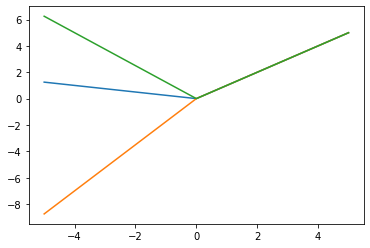

In [77]:
# plot the function for various "anomalous" levels of alpha
prelu_fun = ParamReLU_Trainable_Fun.apply
y1 = prelu_fun(x, torch.full_like(x, -0.25))
y2 = prelu_fun(x, torch.full_like(x, 1.75))
y3 = prelu_fun(x, torch.full_like(x, -1.25))
plt.plot(x.detach().numpy(), y1.detach().numpy())
plt.plot(x.detach().numpy(), y2.detach().numpy())
plt.plot(x.detach().numpy(), y3.detach().numpy())

In [78]:
class ParamReLU_Trainable(torch.nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.Tensor(in_features))
        self.alpha.data.uniform_(0, 1)
    
    def forward(self, X):
        return ParamReLU_Trainable_Fun.apply(X, self.alpha)

In [79]:
prelu = ParamReLU_Trainable(x.shape)
print(prelu.alpha)

Parameter containing:
tensor([0.1211, 0.0826, 0.6742, 0.2233, 0.7059, 0.7104, 0.2532, 0.0841, 0.9580,
        0.0493, 0.5577], requires_grad=True)


In [80]:
y = prelu(x)
print(y)

tensor([-0.6056, -0.3306, -2.0226, -0.4465, -0.7059,  0.0000,  1.0000,  2.0000,
         3.0000,  4.0000,  5.0000], grad_fn=<ParamReLU_Trainable_FunBackward>)


In [81]:
z = y.sum() * 2
z.backward()
print(prelu.alpha.grad)
print(x.grad)

tensor([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   0.,   0.,   0.,   0.,   0.])
tensor([0.2523, 0.1753, 1.3584, 0.4565, 1.4219, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000])


Let us put this inside our MLP and see how things work out...

In [82]:
from scripts import train
from scripts import mnist

In [83]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28*28, 16),
            ParamReLU_Trainable(16),

            torch.nn.BatchNorm1d(num_features=16),
            torch.nn.Linear(16, 32),
            ParamReLU_Trainable(32),

            torch.nn.BatchNorm1d(num_features=32),
            torch.nn.Linear(32, 24),
            ParamReLU_Trainable(24),

            torch.nn.BatchNorm1d(num_features=24),
            torch.nn.Linear(24, 10)
        )
        
    def forward(self, X):
        return self.layers(X)

In [84]:
net = MLP()

First, let us inspect alphas

In [85]:
def inspect_alphas(net):
    for name, param in net.named_parameters():
        if "alpha" in name:
            print(name, "\n", param, "\n")
inspect_alphas(net)

layers.2.alpha 
 Parameter containing:
tensor([0.0604, 0.7725, 0.9243, 0.8475, 0.2735, 0.5951, 0.7301, 0.5049, 0.5192,
        0.9736, 0.3689, 0.5130, 0.7367, 0.0038, 0.3016, 0.0847],
       requires_grad=True) 

layers.5.alpha 
 Parameter containing:
tensor([0.3525, 0.4532, 0.6477, 0.6796, 0.4021, 0.7862, 0.2684, 0.0325, 0.9922,
        0.5411, 0.4065, 0.8873, 0.0843, 0.9704, 0.4443, 0.7644, 0.0823, 0.0850,
        0.0638, 0.7565, 0.5790, 0.3540, 0.5743, 0.6569, 0.9876, 0.6592, 0.7747,
        0.0544, 0.2685, 0.7764, 0.4674, 0.8546], requires_grad=True) 

layers.8.alpha 
 Parameter containing:
tensor([0.8991, 0.6584, 0.0964, 0.7347, 0.0137, 0.4163, 0.8457, 0.8000, 0.4135,
        0.9752, 0.1129, 0.2621, 0.7205, 0.1210, 0.3668, 0.7474, 0.4876, 0.1266,
        0.6933, 0.0639, 0.3908, 0.0077, 0.4417, 0.5983], requires_grad=True) 



Then, train our network...

In [86]:
optim = torch.optim.Adam(net.parameters())
loss = torch.nn.CrossEntropyLoss()
num_epochs = 5
trainloader, testloader, _, _ = mnist.get_data()
train.train_model(net, trainloader, loss, optim, num_epochs)

Epoch 1 --- learning rate 0.00100
Epoch 1 completed. Loss - total: 37528.09336566925 - average: 0.6254682227611542; Performance: 0.8556
Epoch 2 --- learning rate 0.00100
Epoch 2 completed. Loss - total: 15721.543184280396 - average: 0.2620257197380066; Performance: 0.9292
Epoch 3 --- learning rate 0.00100
Epoch 3 completed. Loss - total: 11931.177946090698 - average: 0.1988529657681783; Performance: 0.94285
Epoch 4 --- learning rate 0.00100
Epoch 4 completed. Loss - total: 10047.797733783722 - average: 0.16746329556306203; Performance: 0.95115
Epoch 5 --- learning rate 0.00100
Epoch 5 completed. Loss - total: 8774.140967845917 - average: 0.14623568279743196; Performance: 0.9568


(8774.140967845917, 0.9568)

In [87]:
train.test_model(net, testloader)

TESTING - loss -- - performance 0.9644


(None, 0.9644)

Actually, our model is not performing bad at all.

Let us check the values of the $\alpha$s after training:

In [88]:
inspect_alphas(net)

layers.2.alpha 
 Parameter containing:
tensor([ 0.0708,  0.6065,  0.9148,  1.0027, -0.1245,  0.5505,  0.8336,  0.2537,
         0.5778,  0.6238,  0.2615,  0.3071,  0.3740,  0.0476,  0.1439,  0.2131],
       device='cuda:0', requires_grad=True) 

layers.5.alpha 
 Parameter containing:
tensor([ 0.0804,  0.1619,  0.3887,  0.3792,  0.0809,  0.5028,  0.1617, -0.1083,
         0.8685,  0.1645, -0.0507,  0.6025, -0.0516,  0.1714,  0.2229,  0.5491,
         0.0339,  0.0690, -0.2053,  0.6816,  0.1938,  0.3507,  0.5370,  0.2937,
         0.8534,  0.7514,  0.3164, -0.0669,  0.1176,  1.0896,  0.5157,  0.2972],
       device='cuda:0', requires_grad=True) 

layers.8.alpha 
 Parameter containing:
tensor([ 0.6748,  0.7048,  0.0569,  0.5290, -0.2156,  0.4037,  0.7475,  0.8153,
         0.1236,  0.8415,  0.1510,  0.3700,  0.9145,  0.2305,  0.0718,  0.4609,
         0.5782,  0.1087,  0.2809, -0.0821,  0.6920, -0.0487,  0.5023,  0.6003],
       device='cuda:0', requires_grad=True) 

